In [1]:
import glob
import os.path as osp
import pickle
import random
import numpy as np
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt

import datasets.dataset as dataset
from datasets.load_adni import load_adni2
import models.models as models
from utils.data_class import BrainDataset
import torchio as tio
from tqdm import tqdm
#from models.models import Vgg16, FujiNet1

/home/balt/medical-team-onboarding2024/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# dataloader作成時にラベル情報を数値に変換するために使用するdict型変数
CLASS_MAP = {
    "CN": 0,
    "AD": 1,
}
# 再現性を保つために設定しておく値
SEED_VALUE = 0

In [3]:
# seed値を設定（random, Numpy, PyTorch）
def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = (
        False  # この行をFalseにすると再現性はとれるが、速度が落ちる
    )
    torch.backends.cudnn.deterministic = True
    return

fix_seed(0)

In [4]:
# 脳MRIの画像を読み込み（今回は"CN", "AD"のみ）
dataset = load_adni2(classes=["CN", "AD"],size="half", unique=True, mni=False, strength=["3.0"])

# datasetの枚数を表示
len(dataset)

100%|██████████| 571/571 [00:35<00:00, 15.98it/s]


571

In [5]:
# datasetの1枚の情報を見てみる
dataset[0]

{'pid': '098_S_4003',
 'sex': 'F',
 'age': '72.4137',
 'weight': '56.7',
 'day': '2011-03-22',
 'uid': '225425',
 'preprocessing': 'MT1; GradWarp; N3m',
 'slice_thickness': '1.2',
 'plane': 'SAGITTAL',
 'x': '1.0156',
 'y': '1.0156',
 'manufacturer': 'GE MEDICAL SYSTEMS',
 'model': 'DISCOVERY MR750',
 'strength': '3.0',
 'class': 'CN',
 'mmse': '30.0',
 'moca': '24.0',
 'class_base': 'CN',
 'mmse_base': '30.0',
 'moca_base': '24.0',
 'path_full': '/data2/radiology_datas/clean3/ADNI2/full/rigid/225425.nii',
 'path_half': '/data2/radiology_datas/clean3/ADNI2/half/rigid/225425.nii',
 'path_full_mni': '/data2/radiology_datas/clean3/ADNI2/full/trsaa/225425.nii',
 'path_half_mni': '/data2/radiology_datas/clean3/ADNI2/half/trsaa/225425.nii',
 'voxel': memmap([[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ...

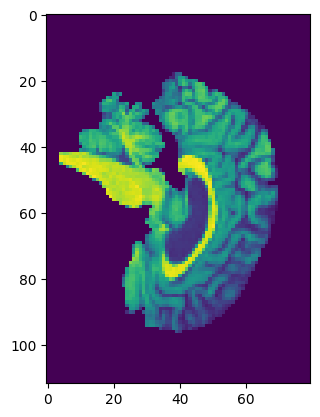

In [6]:
# datasetの画像を1枚見てみる
%matplotlib inline
plt.imshow(dataset[0]["voxel"][40,:,:])

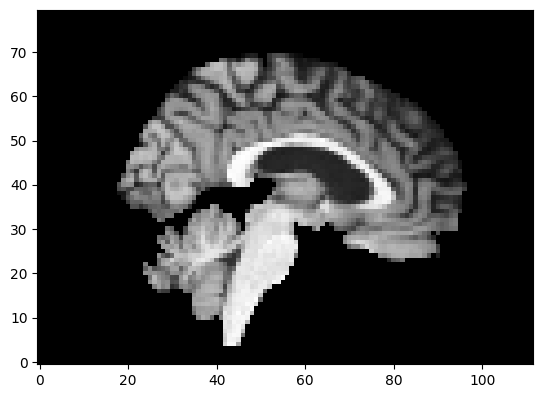

In [7]:
# datasetの画像を1枚見てみる
%matplotlib inline
plt.imshow(dataset[0]["voxel"][40,:,:].T, origin="lower", cmap="gray")

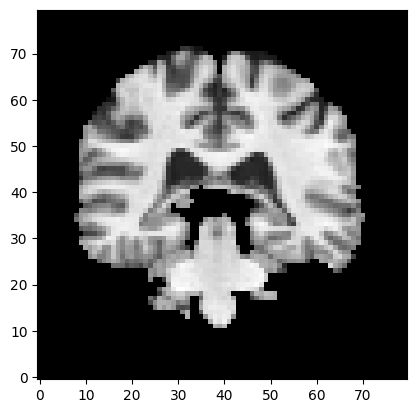

In [8]:
# datasetの画像を1枚見てみる
%matplotlib inline
plt.imshow(dataset[0]["voxel"][:,48,:].T, origin="lower", cmap="gray")

In [9]:
# datasetの」中から使用する情報をそれぞれ取ってくる
pids = []
voxels = np.zeros((len(dataset), 80, 112, 80))
labels = np.zeros(len(dataset))
for i in tqdm(range(len(dataset))):
    pids.append(dataset[i]["pid"])
    voxels[i] = dataset[i]["voxel"]
    # voxels[i] = normalize(voxels[i], np.min(voxels[i]), np.max(voxels[i]))
    labels[i] = CLASS_MAP[dataset[i]["class"]]
pids = np.array(pids)

100%|██████████| 571/571 [00:02<00:00, 214.36it/s]


In [10]:
# trainとtest用の画像を、同じ患者が分かれて入らないように分ける。

from sklearn.model_selection import StratifiedGroupKFold, train_test_split

# train_datadict, val_datadict = train_test_split(dataset, test_size=0.2, shuffle=True, random_state=SEED_VALUE)

pids = []
for i in range(len(dataset)):
    pids.append(dataset[i]["pid"])
gss = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED_VALUE)
train_idx, val_idx = list(gss.split(voxels,labels, groups=pids))[0]
train_voxels = voxels[train_idx]
val_voxels = voxels[val_idx]
train_labels = labels[train_idx]
val_labels = labels[val_idx]

len(train_voxels)

456

In [11]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(0)

In [12]:
# train/val dataset を作成
train_set = BrainDataset(train_voxels, train_labels)
val_set = BrainDataset(val_voxels, val_labels)

print("size of the training dataset = ", len(train_set))
print("size of the validation dataset = ", len(val_set))
print("training image shape = {}, training label = {}".format(train_set(0)[0].shape, train_set(0)[1]))
print("test image shape = {}, test label = {}".format(val_set(0)[0].shape, val_set(0)[1]))

size of the training dataset =  456
size of the validation dataset =  115
training image shape = (1, 80, 112, 80), training label = 0.0
test image shape = (1, 80, 112, 80), test label = 0.0


In [13]:
# Function line up input images and output images
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error


def show_image(image):    
    %matplotlib inline

    fig = plt.figure(figsize=(18,5),dpi=600)
    X, Y = 1, 6
    
    for i in range(6):
        imgplot = i + 1
        ax1 = fig.add_subplot(X, Y, imgplot)
        print(f"type={image.dtype}")
        img = np.flip(image.reshape(80, 112, 80).transpose(1,2,0)[50+i],0)
        plt.axis("off")
        plt.imshow(img,cmap="gray")
        plt.tick_params(labelsize=8)
        
    plt.show()

type=float32
type=float32
type=float32
type=float32
type=float32
type=float32


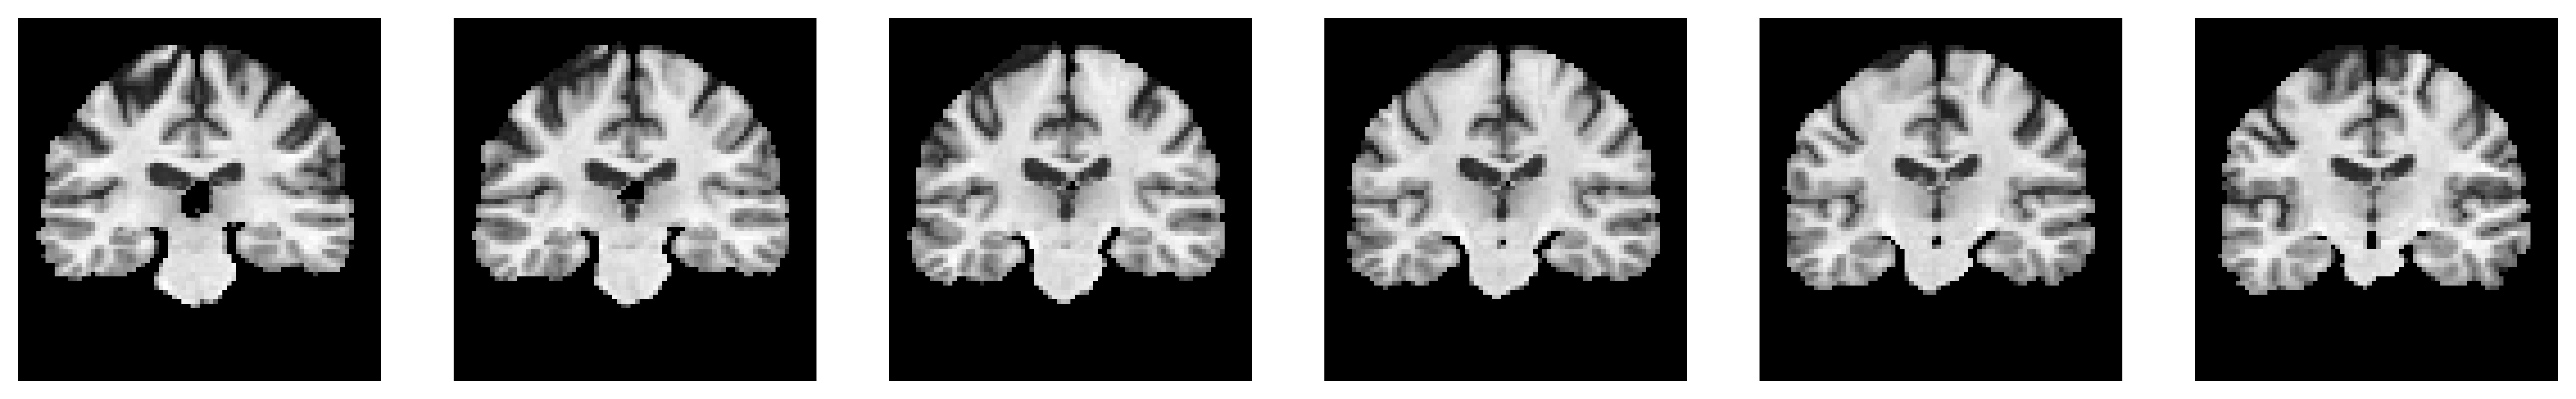

In [14]:
idx = 20
image, label = train_set(idx)

show_image(image)

mean= 0.13431239
max=1.0 min=0.0
0.0


/tmp/ipykernel_2502401/589869620.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


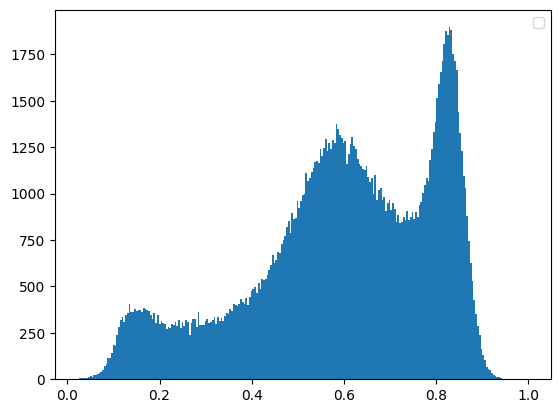

In [15]:
# 画像１枚あたりの輝度値ヒストグラム
print("mean=", image.mean())
print(f"max={image.max()} min={image.min()}")
print(label)
#imge = np.clip(image, 0, None)
show_img = image.reshape(80*112*80)
plt.hist(show_img[show_img > 0.01], bins=255)
#plt.title("Accuracy")
#plt.xlabel("Epoch")
#plt.ylabel("Accuracy")
plt.legend()

571


(array([1.02000e+02, 2.71000e+02, 5.02000e+02, 8.44000e+02, 1.39800e+03,
        2.05400e+03, 2.87700e+03, 3.66600e+03, 4.71100e+03, 6.06900e+03,
        7.46600e+03, 9.24900e+03, 1.14480e+04, 1.41570e+04, 1.69070e+04,
        2.01130e+04, 2.43240e+04, 2.88540e+04, 3.41290e+04, 4.04420e+04,
        4.70330e+04, 5.42280e+04, 6.24160e+04, 7.05740e+04, 7.93940e+04,
        8.94480e+04, 9.89030e+04, 1.08930e+05, 1.19000e+05, 1.29422e+05,
        1.39804e+05, 1.51134e+05, 1.61218e+05, 1.71952e+05, 1.83945e+05,
        1.94296e+05, 2.06093e+05, 2.14392e+05, 2.22193e+05, 2.29637e+05,
        2.35215e+05, 2.38163e+05, 2.39691e+05, 2.39949e+05, 2.38516e+05,
        2.36014e+05, 2.32964e+05, 2.30292e+05, 2.25899e+05, 2.23759e+05,
        2.19174e+05, 2.16044e+05, 2.12820e+05, 2.10655e+05, 2.06574e+05,
        2.04247e+05, 2.00943e+05, 1.98417e+05, 1.95716e+05, 1.92573e+05,
        1.91269e+05, 1.90242e+05, 1.87203e+05, 1.87179e+05, 1.85957e+05,
        1.85255e+05, 1.85051e+05, 1.84688e+05, 1.84

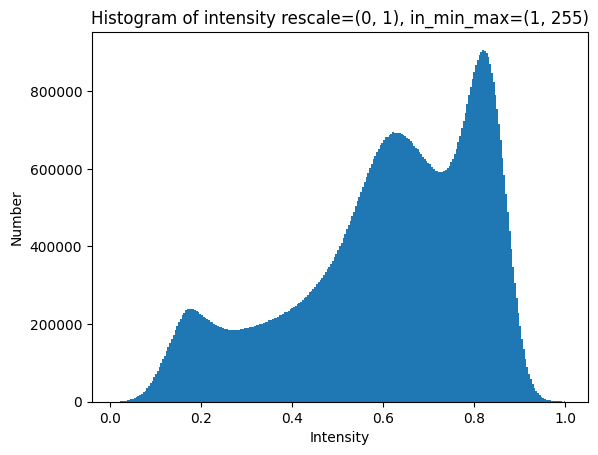

In [16]:
image_list = []
max = 0.01
for image, label in train_set:
    if max < image.max():
        max = image.max()
    image_reshape = image.reshape(80*112*80)
    image_list.append(image_reshape)

for image, label in val_set:
    if max < image.max():
        max = image.max()
    image_reshape = image.reshape(80*112*80)
    image_list.append(image_reshape)
print(len(image_list))

imagelist = np.concatenate(image_list)
plt.title("Histogram of intensity rescale=(0, 1), in_min_max=(1, 255)")
plt.xlabel("Intensity")
plt.ylabel("Number")
plt.hist(imagelist[imagelist > 0.01], bins=255)

In [17]:
print(max)

1.0


In [18]:
train_dataloader = DataLoader(train_set, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=16, shuffle=False)

In [19]:
net = models.CAE3D()
print(net)

CAE3D(
  (encoder): Sequential(
    (0): Conv3d(1, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv3d(3, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): ReLU()
    (5): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (6): ReLU()
    (7): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (9): ReLU()
    (10): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (11): ReLU()
    (12): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=89600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (defc1): Linear(in_features=256, out_features=512, bias=True)
  (defc2): Linear(in_fea

In [20]:
criterion = nn.MSELoss()
#optimizer = optim.SGD(params=net.parameters(), lr=0.0005, momentum=0.9)
optimizer = optim.Adam(params=net.parameters(), lr=0.001)

In [21]:
def train_model(net, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, log_path="./log/3DCAE/"):
    import os
    os.makedirs(log_path, exist_ok=True)

    #nvidia-smiで確認してからcudaの番号を決める
    device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
    net.to(device)
    print("Use divice = ", device)
    
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        # train
        net.train()
        loss_avg = 0.0
        
        for inputs, labels in train_dataloader:
            inputs = inputs.to(device=device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.long)

            optimizer.zero_grad()

            outputs,encoded = net(inputs)
            loss = criterion(outputs, inputs)

            loss.backward()
            optimizer.step()

            loss_avg += loss.item() / len(train_dataloader)
        train_losses.append(loss_avg)

        # evaluate
        loss_avg = 0.0 
      
        net.eval()
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device=device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.long)
            with torch.no_grad():
                outputs,encoded = net(inputs)
                loss = criterion(outputs, inputs)
            
            
            loss_avg += loss.item() / len(val_dataloader)

        test_losses.append(loss_avg)
        print(f"EPOCH {epoch+1}  || train loss : {train_losses[epoch]:.4f}, test loss : {test_losses[epoch]:.4f}")

    torch.save(net.state_dict(), os.path.join(log_path, f"3DCAE_{epoch+1}.pth"))

    import matplotlib.pyplot as plt

    # Lossグラフ作成
    plt.figure(figsize=(8,6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(log_path, 'loss_curve.png'))  # 画像保存
    plt.show()


Use divice =  cuda:5
EPOCH 1  || train loss : 0.1373, test loss : 0.1298
EPOCH 2  || train loss : 0.0512, test loss : 0.0327
EPOCH 3  || train loss : 0.0246, test loss : 0.0432
EPOCH 4  || train loss : 0.0187, test loss : 0.0324
EPOCH 5  || train loss : 0.0164, test loss : 0.0255
EPOCH 6  || train loss : 0.0150, test loss : 0.0243
EPOCH 7  || train loss : 0.0143, test loss : 0.0146
EPOCH 8  || train loss : 0.0136, test loss : 0.0136
EPOCH 9  || train loss : 0.0131, test loss : 0.0171
EPOCH 10  || train loss : 0.0129, test loss : 0.0128
EPOCH 11  || train loss : 0.0127, test loss : 0.0135
EPOCH 12  || train loss : 0.0125, test loss : 0.0123
EPOCH 13  || train loss : 0.0119, test loss : 0.0116
EPOCH 14  || train loss : 0.0117, test loss : 0.0121
EPOCH 15  || train loss : 0.0116, test loss : 0.0114
EPOCH 16  || train loss : 0.0115, test loss : 0.0123
EPOCH 17  || train loss : 0.0114, test loss : 0.0122
EPOCH 18  || train loss : 0.0111, test loss : 0.0119
EPOCH 19  || train loss : 0.0110, 

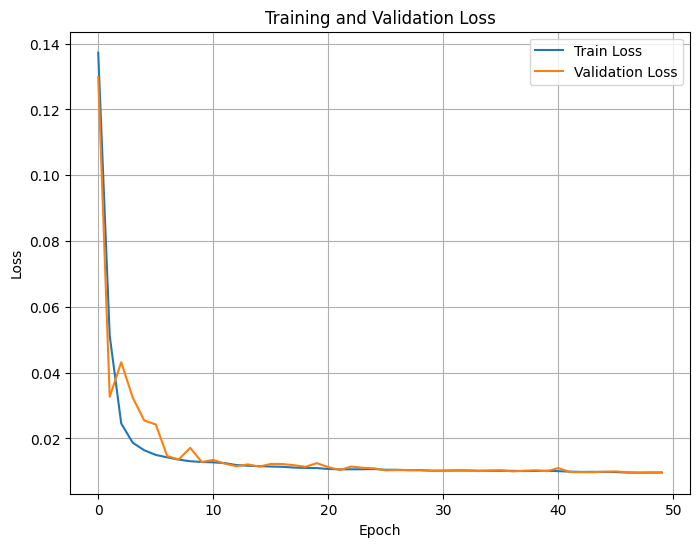

In [22]:
num_epochs = 50


train_model(net, train_dataloader, val_dataloader, criterion, optimizer, num_epochs)

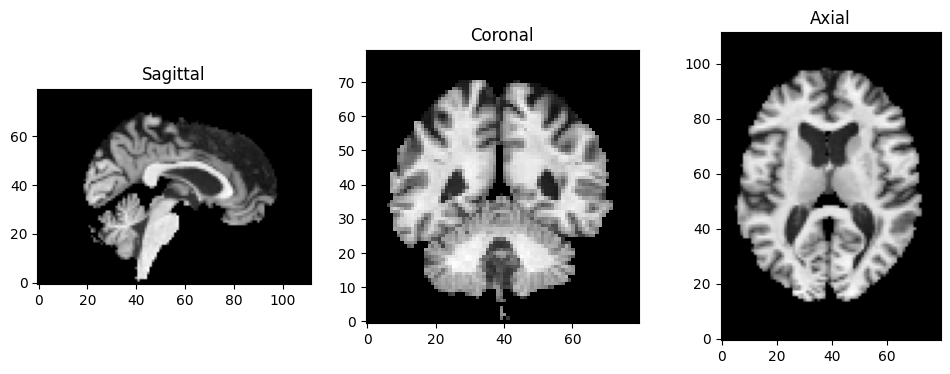

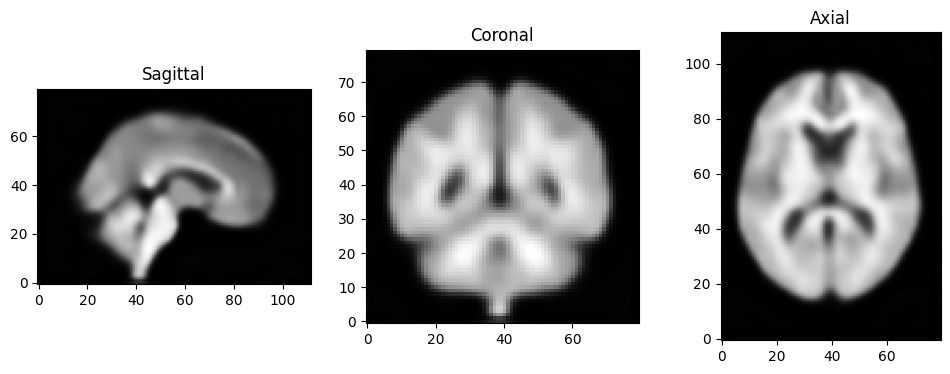

In [23]:
image,label=val_set(0)

device=torch.device("cuda:5" if torch.cuda.is_available() else "cpu")

image=torch.from_numpy(image).unsqueeze(0).to(device,dtype=torch.float32)

net.eval()
with torch.no_grad():
    outputs,encoded=net(image)


image=image.cpu().numpy()[0,0]
outputs=outputs.cpu().numpy()[0,0]

def show_slices_3planes(volume,sagittal=40,colonal=40,axial=40):
    sagittal_slice=volume[sagittal,:,:]
    colonal_slice=volume[:,colonal,:]
    axial_slice=volume[:,:,axial]

    import matplotlib.pyplot as plt

    fig,axes=plt.subplots(1,3,figsize=(12,4))
    axes[0].imshow(sagittal_slice.T,origin="lower",cmap="gray")
    axes[0].set_title("Sagittal")
    axes[1].imshow(colonal_slice.T,origin="lower",cmap="gray")
    axes[1].set_title("Coronal")
    axes[2].imshow(axial_slice.T,origin="lower",cmap="gray")
    axes[2].set_title("Axial")

    plt.show()

show_slices_3planes(image)
show_slices_3planes(outputs)

In [24]:
def extract_latent_features(net, dataloader):
    net.eval()
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device, dtype=torch.float32)
            _, encoded = net(images)  # <- ここを修正！
            encoded = encoded.cpu().numpy()
            all_features.append(encoded)
            all_labels.append(labels.numpy())

    return np.concatenate(all_features), np.concatenate(all_labels)


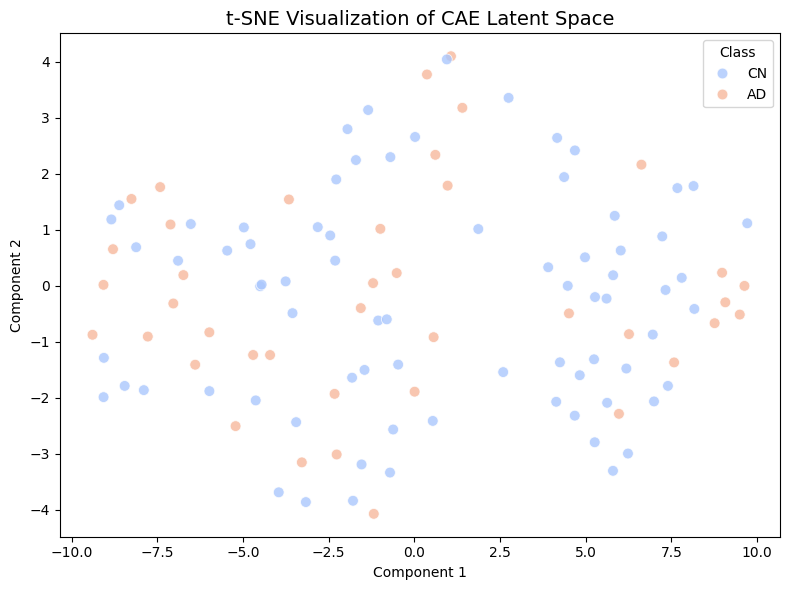

In [25]:
# from sklearn.manifold import TSNE
# import seaborn as sns
# import matplotlib.pyplot as plt

# all_features, all_labels = extract_latent_features(net, val_dataloader)

# tsne = TSNE(n_components=2, random_state=0)
# features_2d = tsne.fit_transform(all_features)

# plt.figure(figsize=(6,5))
# sns.scatterplot(x=features_2d[:,0], y=features_2d[:,1], 
#                 hue=all_labels, palette="Set1")
# plt.title("t-SNE visualization of CAE latent space")
# plt.legend(labels=["CN", "AD"])  # CLASS_MAP に合わせる
# plt.show()

from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 特徴量とラベルの取得
all_features, all_labels = extract_latent_features(net, val_dataloader)

# t-SNE 実行
tsne = TSNE(n_components=2, random_state=0)
features_2d = tsne.fit_transform(all_features)

# ラベル名（例：0 = CN, 1 = AD）に変換
label_names = {0: "CN", 1: "AD"}
label_series = pd.Series(all_labels).map(label_names)

# 可視化
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=features_2d[:,0],
    y=features_2d[:,1],
    hue=label_series,
    palette="coolwarm",     # 他に: 'viridis', 'Spectral', 'tab10' など
    s=60,                   # 点のサイズ
    alpha=0.8               # 透明度
)

plt.title("t-SNE Visualization of CAE Latent Space", fontsize=14)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Class")
plt.tight_layout()
plt.show()
